In [1]:
%matplotlib inline

#Importing Functions and Libraries

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
import pydataset as data

#Importing pre-written scripts to streamline data acquisition and cleaning:
from acquire import get_zillow_data
from prepare import clean_telco_data, prep_telco_data
from env import get_db_url
from stats_toolkit import significance_test
from wrangle import wrangle_zillow, clearing_fips

In [2]:
df = wrangle_zillow()
df

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,propertylandusedesc,county
4,4,2.0,3633.0,296425.0,2005,6941.39,Single Family Residential,Los Angeles County
6,3,4.0,1620.0,847770.0,2011,10244.94,Single Family Residential,Los Angeles County
7,3,2.0,2077.0,646760.0,1926,7924.68,Single Family Residential,Los Angeles County
11,0,0.0,1200.0,5328.0,1972,91.60,Single Family Residential,Los Angeles County
14,0,0.0,171.0,6920.0,1973,255.17,Single Family Residential,Los Angeles County
...,...,...,...,...,...,...,...,...
2152856,4,4.0,4375.0,422400.0,2015,13877.56,Single Family Residential,Los Angeles County
2152858,4,3.0,2262.0,960756.0,2015,13494.52,Single Family Residential,Orange County
2152859,4,4.5,3127.0,536061.0,2014,6244.16,Single Family Residential,Orange County
2152861,3,2.5,1974.0,424353.0,2015,5302.70,Single Family Residential,Orange County


In [3]:
train_and_validate, test = train_test_split(df, test_size = .2, random_state=123)
train, validate = train_test_split(train_and_validate, test_size = .3, random_state = 123)

In [4]:
train.columns.tolist()

['bedroomcnt',
 'bathroomcnt',
 'calculatedfinishedsquarefeet',
 'taxvaluedollarcnt',
 'yearbuilt',
 'taxamount',
 'propertylandusedesc',
 'county']

# Exercises:

## 1. Apply the scalers we talked about in this lesson to your data and visualize the results for the unscaled and scaled distribution.

In [5]:
#Creating separate test/validate dataframes for the variables I want to scale, and separating their respective target variables, in a single step.
X_train, X_test = train[['calculatedfinishedsquarefeet', 'taxamount']], test[['calculatedfinishedsquarefeet', 'taxamount']]
y_train, y_test = train.taxvaluedollarcnt, test.taxvaluedollarcnt

In [6]:
X_test

,calculatedfinishedsquarefeet,taxamount
663837,841.0,2123.73
745486,1719.0,3318.95
1170071,1505.0,3393.22
28048,1230.0,2837.94
1034274,1640.0,3801.66
...,...,...
172946,1284.0,4470.16
1081817,1863.0,3629.14
1043617,2325.0,4848.72
1703282,1862.0,3099.61


### Min-Max Scaler:

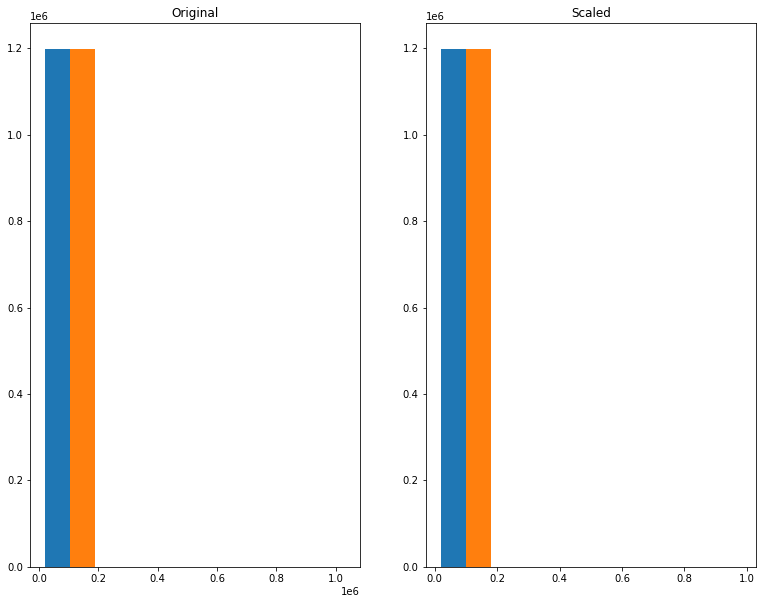

In [29]:
scaler = MinMaxScaler()
#fit_transform is a way to do .fit and .transform in a single line, but the effect is the same.
X_train_scaled = scaler.fit_transform(X_train)

plt.figure(figsize=(13, 10))
plt.subplot(121)
plt.hist(X_train, bins=5)
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=5)
plt.title('Scaled');

In [8]:
scaler.fit_transform(X_train)

array([[0.0036828 , 0.00562743],
       [0.0028939 , 0.00413077],
       [0.00229893, 0.00524114],
       ...,
       [0.00222738, 0.00422042],
       [0.0033872 , 0.00503052],
       [0.00403678, 0.00670161]])

### Standard Scaler:

Text(0.5, 1.0, 'Scaled')

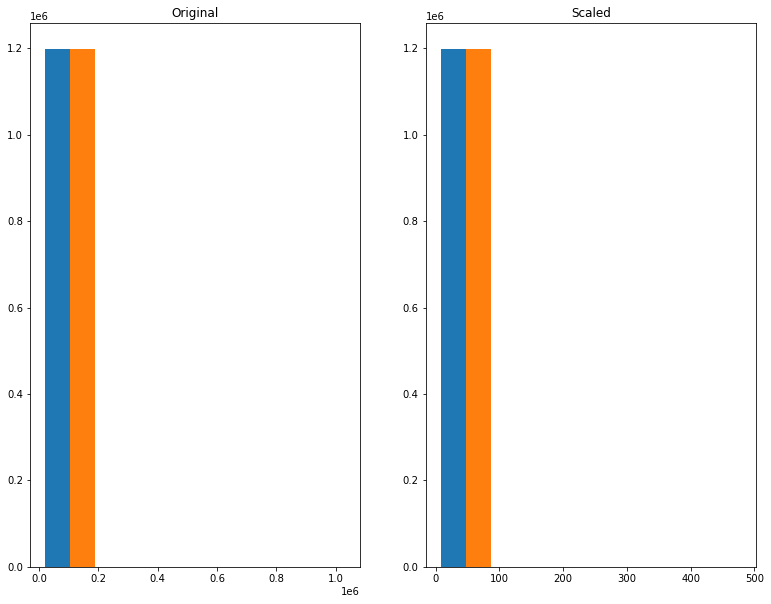

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(13, 10))
plt.subplot(121)
plt.hist(X_train, bins=5)
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=5)
plt.title('Scaled')

Text(0.5, 1.0, 'Scaled')

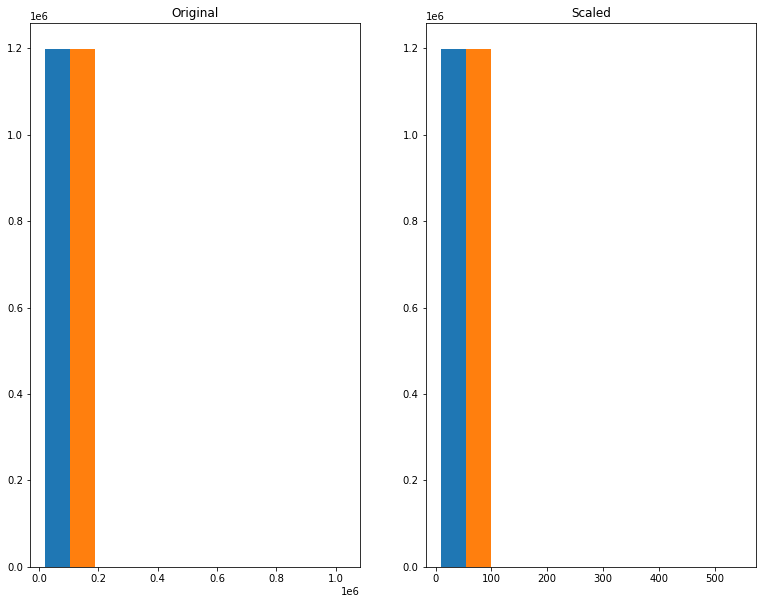

In [22]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(13, 10))
plt.subplot(121)
plt.hist(X_train, bins=5)
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=5)
plt.title('Scaled')

## 2. Apply the .inverse_transform method to your scaled data. Is the resulting dataset the exact same as the original data?

In [11]:
#Recreating the scaled dataset with the min-max scaler:
scaler = MinMaxScaler()
#fit_transform is a way to do .fit and .transform in a single line, but the effect is the same.
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [12]:
#Running inverse_transform to try to revert the data to its original form (i.e. run the scaler in reverse to get original data):
scaler.inverse_transform(X_train_scaled)

array([[1957.  , 5926.76],
       [1538.  , 4352.18],
       [1222.  , 5520.36],
       ...,
       [1184.  , 4446.49],
       [1800.  , 5298.77],
       [2145.  , 7056.86]])

In [13]:
#Checking whether the inverse_transformed data is truly reverted back to the form of the original data:
(X_train == scaler.inverse_transform(X_train_scaled)).value_counts()

calculatedfinishedsquarefeet  taxamount
True                          True         1181211
False                         True           13328
True                          False           3886
False                         False             49
dtype: int64

The above shows that although I ran the inverse_transform function, the data didn't go 100% back to its original form. This is likely due to how Python handles floats in calculations, so the variation could be due to rounding errors. 

## 3. Read the documentation for sklearn's QuantileTransformer. Use normal for the output_distribution and apply this scaler to your data. Visualize the result of your data scaling.

In [14]:
df[['calculatedfinishedsquarefeet']]

,calculatedfinishedsquarefeet
4,3633.0
6,1620.0
7,2077.0
11,1200.0
14,171.0
...,...
2152856,4375.0
2152858,2262.0
2152859,3127.0
2152861,1974.0


In [15]:
qt = df[['calculatedfinishedsquarefeet']]
qnt_transformer = QuantileTransformer(output_distribution = 'normal')
qnt_transformer.fit(qt)

QuantileTransformer(output_distribution='normal')

In [16]:
scaled_qt = qnt_transformer.transform(qt)
qt['sqft_scaled'] = scaled_qt
qt

,calculatedfinishedsquarefeet,sqft_scaled
4,3633.0,1.701906
6,1620.0,-0.011291
7,2077.0,0.544759
11,1200.0,-0.816150
14,171.0,-3.320252
...,...,...
2152856,4375.0,2.027534
2152858,2262.0,0.720629
2152859,3127.0,1.396812
2152861,1974.0,0.439922


Text(0.5, 1.0, 'Scaled')

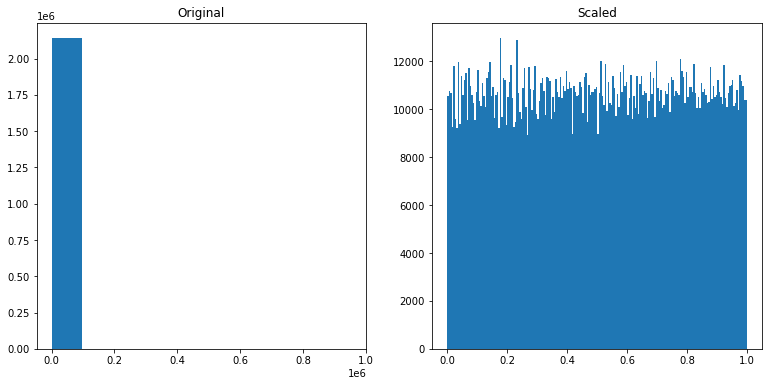

In [26]:
#Copied Adam's code and changed variables to graph distributions:
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(qt['calculatedfinishedsquarefeet'], bins=10)
plt.title('Original')
plt.subplot(122)
plt.hist(qt['sqft_scaled'], bins=200)
plt.title('Scaled')

The above shows that the quantile transformer converts non-normal data, and as Adam puts it, 'smushificates' it to force it into a normal distribution. One aspect of this is that it diminishes the impact of outliers. 

## 4. Use the QuantileTransformer, but omit the output_distribution argument. Visualize your results. What do you notice?

In [18]:
qt = df[['calculatedfinishedsquarefeet']]
qnt_transformer = QuantileTransformer()
qnt_transformer.fit(qt)

QuantileTransformer()

In [19]:
scaled_qt = qnt_transformer.transform(qt)
qt['sqft_scaled'] = scaled_qt
qt

,calculatedfinishedsquarefeet,sqft_scaled
4,3633.0,0.954621
6,1620.0,0.499499
7,2077.0,0.710043
11,1200.0,0.207207
14,171.0,0.000184
...,...,...
2152856,4375.0,0.978795
2152858,2262.0,0.767768
2152859,3127.0,0.919319
2152861,1974.0,0.673674


Text(0.5, 1.0, 'Scaled')

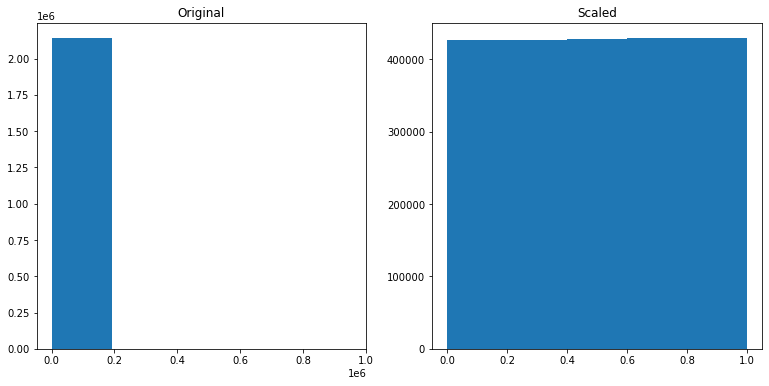

In [31]:
#Copied Adam's code and changed variables to graph distributions:
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(qt['calculatedfinishedsquarefeet'], bins=5)
plt.title('Original')
plt.subplot(122)
plt.hist(qt['sqft_scaled'], bins=5)
plt.title('Scaled')

Without specifying that the output_distribution should 'smushificate' the data into a normal distribution, the output appears to be standardized when scaled. 

## 5. Based on the work you've done, choose a scaling method for your dataset. Write a function within your prepare.py that accepts as input the train, validate, and test data splits, and returns the scaled versions of each. Be sure to only learn the parameters for scaling from your training data!

How does one evaluate which scaler is best to use for something like this? Is it based on which ones are most true to the original data when put through inverse_transform?

In [36]:
def scale_zillow_data(train, validate, test):
    
    '''
    Takes in train, validate, and test sets, creates copies of those sets, and
    scales the copies. Returns train_scaled, validate_scaled, and test_scaled 
    DataFrames.
    '''
    
    #Defining the columns that need to be scaled:
    scaled_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt']
    
    #Creating scalable copies of the train, validate, and test sets:
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    #Creating the scaler object:
    scaler = MinMaxScaler()
    scaler.fit(train[scaled_columns])
    
    #Applying the scaler to the scalable colums within the train, validate, test copies:
    train_scaled[scaled_columns] = scaler.transform(train[scaled_columns])
    validate_scaled[scaled_columns] = scaler.transform(validate[scaled_columns])
    test_scaled[scaled_columns] = scaler.transform(test[scaled_columns])

    #Returning scaled dataframes:
    return train_scaled, validate_scaled, test_scaled

In [37]:
#Using the function to create scaled DataFrames:
train_scaled, validate_scaled, test_scaled = scale_zillow_data(train, validate, test)

In [38]:
#Verifying that the scaler worked properly:
train.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,propertylandusedesc,county
453491,3,2.0,1957.0,490784.0,1949,5926.76,Single Family Residential,Los Angeles County
1899700,4,2.0,1538.0,346396.0,1950,4352.18,Single Family Residential,Los Angeles County
1140176,2,2.0,1222.0,522853.0,1987,5520.36,Single Family Residential,Orange County
1782442,3,3.0,2170.0,145340.0,1959,1914.56,Single Family Residential,Los Angeles County
1553005,4,2.0,1764.0,120029.0,1979,2143.61,Single Family Residential,Los Angeles County


In [39]:
train_scaled.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,propertylandusedesc,county
453491,0.12,0.10,0.003683,0.005576,1949,5926.76,Single Family Residential,Los Angeles County
1899700,0.16,0.10,0.002894,0.003935,1950,4352.18,Single Family Residential,Los Angeles County
1140176,0.08,0.10,0.002299,0.005940,1987,5520.36,Single Family Residential,Orange County
1782442,0.12,0.15,0.004084,0.001651,1959,1914.56,Single Family Residential,Los Angeles County
1553005,0.16,0.10,0.003319,0.001363,1979,2143.61,Single Family Residential,Los Angeles County


It's clear that the scaler worked probably, because the bedroom, bathroom, sqft, and tax value columns are all scaled. 